### Comparisons of layers for FLOPs, sizes, input/output connection for different partitioning strategies

In [13]:
import numpy as np
import pandas as pd
import os 
import sys
import itertools
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm

In [14]:
data_folder = "../data/partitioner_data15Oct"
layer_1 = f"{data_folder}/layer_1_conv2d_fused.csv"
layer_2 = f"{data_folder}/layer_2_re_lu.csv"
layer_3 = f"{data_folder}/layer_3_conv2d_1_fused.csv"
layer_4 = f"{data_folder}/layer_4_re_lu_1.csv"
layer_5 = f"{data_folder}/layer_5_conv2d_2_fused.csv"
layer_7 = f"{data_folder}/layer_7_re_lu_2.csv"

In [15]:
# Load NoC comparison data
df_layer1 = pd.read_csv(layer_1)

print(f"\nColumns: {list(df_layer1.columns)}\n")
print(df_layer1.head(3))


Columns: ['layer_index', 'layer_name', 'layer_type', 'partitioning_strategy', 'spatial', 'out_ch', 'in_ch', 'num_partitions', 'mean_partition_size', 'min_partition_size', 'max_partition_size', 'std_partition_size', 'total_size', 'mean_partition_size_input', 'min_partition_size_input', 'max_partition_size_input', 'std_partition_size_input', 'mean_partition_size_output', 'min_partition_size_output', 'max_partition_size_output', 'std_partition_size_output', 'mean_partition_size_weights', 'min_partition_size_weights', 'max_partition_size_weights', 'std_partition_size_weights', 'mean_flops', 'min_flops', 'max_flops', 'std_flops', 'total_flops', 'mean_macs', 'total_macs', 'total_weights', 'mean_input_tensor_size', 'min_input_tensor_size', 'max_input_tensor_size', 'std_input_tensor_size', 'total_input_data', 'number_of_input_connections', 'mean_output_tensor_size', 'min_output_tensor_size', 'max_output_tensor_size', 'std_output_tensor_size', 'total_output_data', 'number_of_output_connections

### Max FLOPS per number of partitions per layer

In [165]:
def plot_flops_comaprison_2d(csv_path, figsize=(3.5, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None, scilimits=(1,1)):
    """    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with NoC comparison results
    figsize : tuple
        Figure size in inches (default: 3.5x2.5 for IEEE 2-column)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include (filters out smaller values)
    max_parts_per_layer : int, optional
        Maximum number of partitions per layer to include (filters out larger values)
    
    Returns:
    --------
    fig, ax1, ax2 : matplotlib objects
    """
    
    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'lines.markersize': 4,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    # For duplicate num_partitions, max the max_flops
    df_averaged = df.groupby('num_partitions').agg({
        'max_flops': 'min', # Keep max_flops as a worse case scenario
        'num_partitions': 'first',  # Keep first value (should be same for duplicates)
    }).reset_index(drop=True)
    
    # Apply min/max partitions filter if specified
    if min_parts_per_layer is not None:
        df_averaged = df_averaged[df_averaged['num_partitions'] >= min_parts_per_layer]
        print(f"Filtering: showing only num_partitions >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_averaged = df_averaged[df_averaged['num_partitions'] <= max_parts_per_layer]
        print(f"Filtering: showing only num_partitions <= {max_parts_per_layer}")
    
    # Sort by parts_per_layer for better visualization
    df_sorted = df_averaged.sort_values('num_partitions')
    
    print(f"Original data: {len(df)} rows")
    print(f"After removing duplicates and filtering: {len(df_sorted)} rows")
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=figsize, dpi=100)
    
    # Plot error (percentage_diff) on left y-axis
    color1 = "#0a619f"  # Blue
    ax1.scatter(df_sorted['num_partitions'], df_sorted['max_flops'], 
                color=color1, marker='o', s=25, alpha=0.7, label='FLOPs', zorder=3)
    ax1.set_xlabel('Partitions', fontweight='normal')
    ax1.set_ylabel('FLOPs', fontweight='normal')  # No color
    ax1.tick_params(axis='y', direction='in')
    ax1.tick_params(axis='x', direction='in', rotation=45)
    ax1.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax1.set_xlim(right=149)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)

    ax1.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax1.ticklabel_format(style='sci', axis='y', scilimits=scilimits)
    
    # Add horizontal grid
    ax1.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    
    # Make top and right spines visible without ticks
    ax1.spines['top'].set_visible(True)
    ax1.spines['right'].set_visible(True)

    # Remove ticks from top axis
    ax1.tick_params(top=False, labeltop=False)

    # Add combined legend - FULLY OPAQUE
    lines1, labels1 = ax1.get_legend_handles_labels()
    #ax1.legend(lines1 , labels1, 
    #            loc='best', frameon=True, framealpha=1.0, edgecolor='black', 
    #            fancybox=False, facecolor='white')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    return fig, ax1

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 3584 rows
After removing duplicates and filtering: 99 rows
Figure saved to: ../data/partitioner_data15Oct/layer1_flops.png


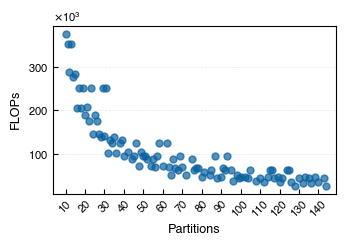

In [168]:
# Generate the plot
fig, ax1 = plot_flops_comaprison_2d(
    csv_path=layer_1,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer1_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 1792 rows
After removing duplicates and filtering: 69 rows


Figure saved to: ../data/partitioner_data15Oct/layer2_flops.png


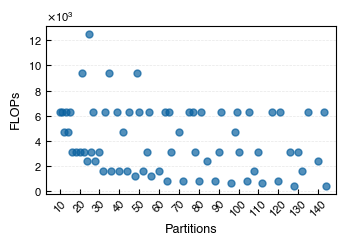

In [169]:
# Generate the plot
fig, ax1 = plot_flops_comaprison_2d(
    csv_path=layer_2,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer2_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 3584 rows
After removing duplicates and filtering: 99 rows
Figure saved to: ../data/partitioner_data15Oct/layer5_flops.png


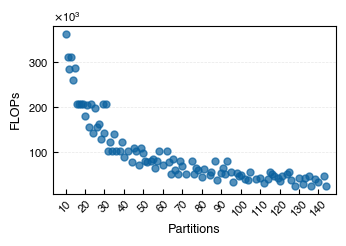

In [170]:
# Generate the plot
fig, ax1 = plot_flops_comaprison_2d(
    csv_path=layer_5,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer5_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 1792 rows
After removing duplicates and filtering: 69 rows
Figure saved to: ../data/partitioner_data15Oct/layer3_flops.png


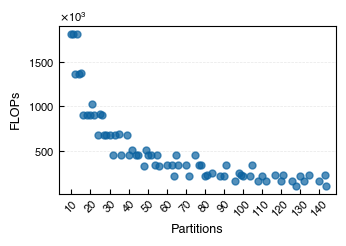

In [171]:
# Generate the plot
fig, ax1 = plot_flops_comaprison_2d(
    csv_path=layer_3,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer3_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 1792 rows
After removing duplicates and filtering: 69 rows
Figure saved to: ../data/partitioner_data15Oct/layer4_flops.png


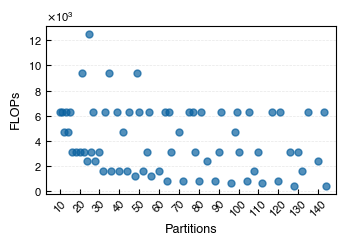

In [172]:
# Generate the plot
fig, ax1 = plot_flops_comaprison_2d(
    csv_path=layer_4,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer4_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 7168 rows
After removing duplicates and filtering: 99 rows
Figure saved to: ../data/partitioner_data15Oct/layer7_flops.png


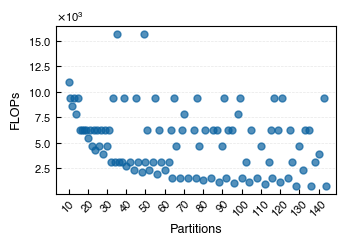

In [173]:
# Generate the plot
fig, ax1 = plot_flops_comaprison_2d(
    csv_path=layer_7,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer7_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

In [201]:
def plot_flops_comparison_3d(csv_path, figsize=(3.5, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None, scilimits=(1,1)):
    """
    Create IEEE conference paper style 3D scatter plot for NoC comparison.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with NoC comparison results
    figsize : tuple
        Figure size in inches (default: 3.5x2.5 for IEEE 2-column)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include (filters out smaller values)
    max_parts_per_layer : int, optional
        Maximum number of partitions per layer to include (filters out larger values)
    
    Returns:
    --------
    fig, ax : matplotlib objects
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.ticker import ScalarFormatter
    from mpl_toolkits.mplot3d import Axes3D

    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'lines.markersize': 4,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    # Normalize strategy names (avoid tuple issues)
    df['partitioning_strategy'] = df['partitioning_strategy'].apply(
        lambda x: "_".join(map(str, x)) if isinstance(x, (tuple, list)) else str(x)
    )
    
    df_sorted = df.copy()
    
    # Apply min/max partitions filter if specified
    if min_parts_per_layer is not None:
        df_sorted = df_sorted[df_sorted['num_partitions'] >= min_parts_per_layer]
        print(f"Filtering: showing only num_partitions >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_sorted = df_sorted[df_sorted['num_partitions'] <= max_parts_per_layer]
        print(f"Filtering: showing only num_partitions <= {max_parts_per_layer}")
    
    # Get distinct configurations in ascending order
    unique_configs = sorted(df_sorted['partitioning_strategy'].unique())
    # Map configurations to y indices
    config_map = {c: i for i, c in enumerate(unique_configs)}
    df_sorted['config_index'] = df_sorted['partitioning_strategy'].map(config_map)
    
    print(f"Original data: {len(df)} rows")
    print(f"After filtering: {len(df_sorted)} rows")
    
    # Normalize max_flops for colormap
    norm = plt.Normalize(df_sorted['max_flops'].min(), df_sorted['max_flops'].max())
    colors = cm.viridis(norm(df_sorted['max_flops']))
    
    # Create 3D figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot scatter
    color1 = "#0a619f"  # Blue
    ax.scatter(df_sorted['num_partitions'], df_sorted['config_index'], df_sorted['max_flops'], 
                color=colors, marker='o', s=15, alpha=0.7, label='FLOPs', depthshade=True)
    
    ax.set_xlabel('Partitions', fontweight='normal')
    ax.set_ylabel('Configuration Index', fontweight='normal')
    ax.set_zlabel('FLOPs', fontweight='normal')
    
    # Set tick parameters
    ax.tick_params(axis='x', direction='in', labelsize=8, width=0.8)
    ax.tick_params(axis='y', direction='in', labelsize=8, width=0.8)
    ax.tick_params(axis='z', direction='in', labelsize=8, width=0.8)
    
    # Set x ticks
    #ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.set_xlim(right=149)
    
    # Set y ticks to show configuration labels
    ax.set_yticks(range(len(unique_configs)))
    ax.set_yticks(range(0, len(unique_configs), 100))

    
    # Set scientific notation for z-axis
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits(scilimits)
    ax.zaxis.set_major_formatter(formatter)
        
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)
    
    #plt.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.95)
    mappable = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    mappable.set_array(df_sorted['max_flops'])
    cbar = fig.colorbar(mappable, ax=ax, pad=0.2, shrink=0.3, label='FLOPs')
    cbar.ax.yaxis.set_major_formatter(formatter)

    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    return fig, ax

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 2722 rows
After filtering: 674 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer1_flops.png


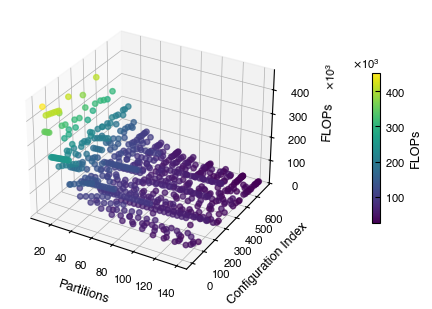

In [202]:
fig3d, ax1 = plot_flops_comparison_3d(csv_path=layer_1,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer1_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()


Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 1792 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer2_flops.png


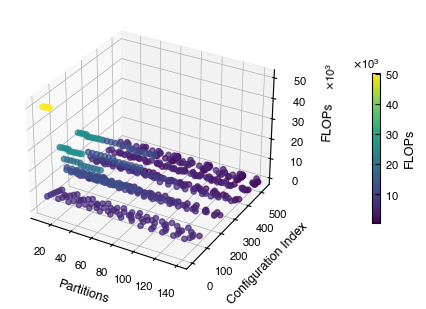

In [176]:
fig3d, ax1 = plot_flops_comparison_3d(csv_path=layer_2,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer2_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 7168 rows
After filtering: 829 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer7_flops.png


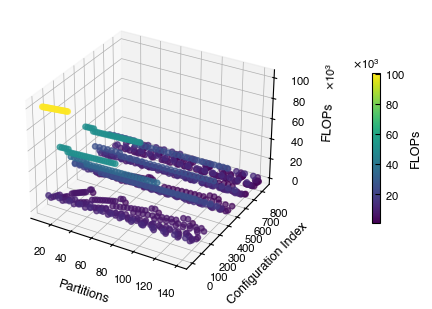

In [203]:
fig3d, ax1 = plot_flops_comparison_3d(csv_path=layer_7,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer7_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

In [178]:
def plot_flops_comparison_surface_3d(csv_path, figsize=(3.5, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None, scilimits=(1,1)):
    """
    Create IEEE conference paper style 3D surface plot for NoC comparison.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with NoC comparison results
    figsize : tuple
        Figure size in inches (default: 3.5x2.5 for IEEE 2-column)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include (filters out smaller values)
    max_parts_per_layer : int, optional
        Maximum number of partitions per layer to include (filters out larger values)
    
    Returns:
    --------
    fig, ax : matplotlib objects
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.ticker import ScalarFormatter
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.cm as cm

    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'lines.markersize': 4,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    # Normalize strategy names (avoid tuple issues)
    df['partitioning_strategy'] = df['partitioning_strategy'].apply(
        lambda x: "_".join(map(str, x)) if isinstance(x, (tuple, list)) else str(x)
    )
    
    df_sorted = df.copy()
    
    # Apply min/max partitions filter if specified
    if min_parts_per_layer is not None:
        df_sorted = df_sorted[df_sorted['num_partitions'] >= min_parts_per_layer]
        print(f"Filtering: showing only num_partitions >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_sorted = df_sorted[df_sorted['num_partitions'] <= max_parts_per_layer]
        print(f"Filtering: showing only num_partitions <= {max_parts_per_layer}")
    
    # Get distinct configurations in ascending order
    unique_configs = sorted(df_sorted['partitioning_strategy'].unique())
    # Map configurations to y indices
    config_map = {c: i for i, c in enumerate(unique_configs)}
    df_sorted['config_index'] = df_sorted['partitioning_strategy'].map(config_map)
    
    print(f"Original data: {len(df)} rows")
    print(f"After filtering: {len(df_sorted)} rows")
    
    # Create 3D figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Surface plot for max_flops
    surf = ax.plot_trisurf(
        df_sorted['num_partitions'],
        df_sorted['config_index'],
        df_sorted['max_flops'],
        cmap='viridis',
        linewidth=0.2,
        antialiased=True,
        alpha=0.8
    )
    
    ax.set_xlabel('Partitions', fontweight='normal')
    ax.set_ylabel('Configuration Index', fontweight='normal')
    ax.set_zlabel('FLOPs', fontweight='normal')
    
    # Set tick parameters
    ax.tick_params(axis='x', direction='in', labelsize=8, width=0.8)
    ax.tick_params(axis='y', direction='in', labelsize=8, width=0.8)
    ax.tick_params(axis='z', direction='in', labelsize=8, width=0.8)
    
    # Set x ticks
    ax.set_xlim(right=149)
    
    # Set y ticks to show configuration labels
    ax.set_yticks(range(len(unique_configs)))
    ax.set_yticks(range(0, len(unique_configs), 100))
    
    # Set scientific notation for z-axis
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits(scilimits)
    ax.zaxis.set_major_formatter(formatter)
        
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Add colorbar
    cbar = fig.colorbar(surf, ax=ax, pad=0.2, shrink=0.3, label='FLOPs')
    cbar.ax.yaxis.set_major_formatter(formatter)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    return fig, ax

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 3584 rows
After filtering: 677 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer1_surface_flops.png


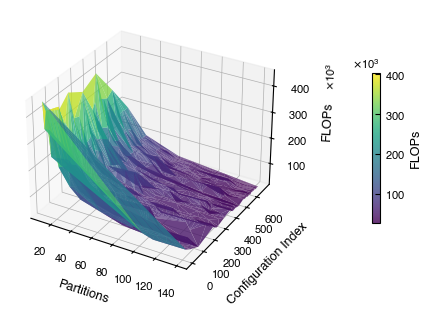

In [179]:
fig3d, ax1 = plot_flops_comparison_surface_3d(csv_path=layer_1,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer1_surface_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 1792 rows
After filtering: 525 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer2_surface_flops.png


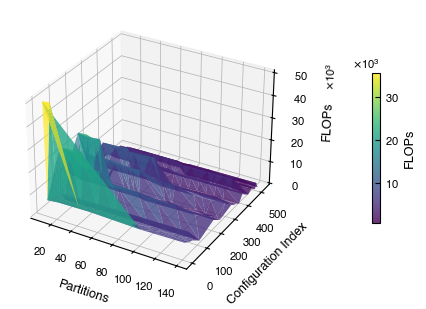

In [180]:
fig3d, ax1 = plot_flops_comparison_surface_3d(csv_path=layer_2,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer2_surface_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 1792 rows
After filtering: 525 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer3_surface_flops.png


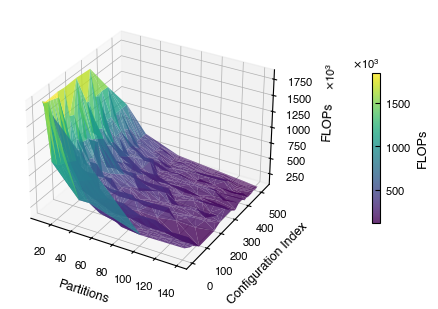

In [181]:
fig3d, ax1 = plot_flops_comparison_surface_3d(csv_path=layer_3,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer3_surface_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 1792 rows
After filtering: 525 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer4_surface_flops.png


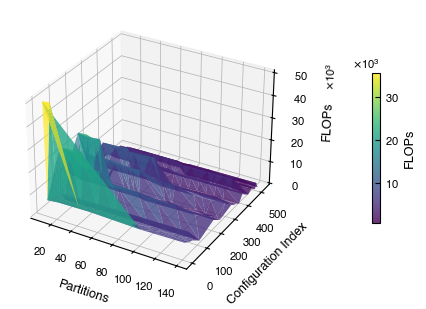

In [182]:
fig3d, ax1 = plot_flops_comparison_surface_3d(csv_path=layer_4,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer4_surface_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 3584 rows
After filtering: 677 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer5_surface_flops.png


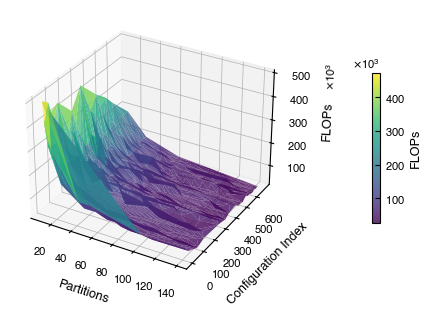

In [183]:
fig3d, ax1 = plot_flops_comparison_surface_3d(csv_path=layer_5,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer5_surface_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 7168 rows
After filtering: 829 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer7_surface_flops.png


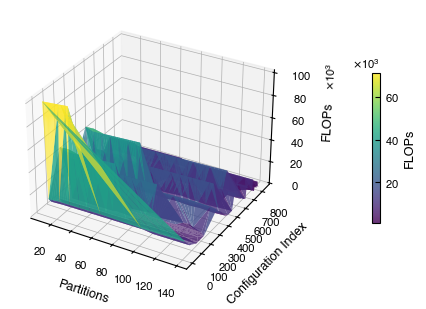

In [184]:
fig3d, ax1 = plot_flops_comparison_surface_3d(csv_path=layer_7,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer7_surface_flops.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

### Sizes of input / output / weights per number of partitions per layer

In [49]:
def plot_size_comaprison_2d(csv_path, figsize=(3.5, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None, scilimits=(1,1)):
    """
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with NoC comparison results
    figsize : tuple
        Figure size in inches (default: 3.5x2.5 for IEEE 2-column)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include (filters out smaller values)
    max_parts_per_layer : int, optional
        Maximum number of partitions per layer to include (filters out larger values)
    
    Returns:
    --------
    fig, ax1, ax2 : matplotlib objects
    """
    
    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'lines.markersize': 4,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })
    
    # Read data
    df = pd.read_csv(csv_path)
    
    # For duplicate num_partitions, max the max_flops
    df_averaged = df.groupby('num_partitions').agg({
        'mean_partition_size': 'min', # Keep mean_partition_size as a worse case scenario
        'mean_partition_size_input': 'min', 
        'min_partition_size_input': 'min', 
        'max_partition_size_input': 'min', 
        'std_partition_size_input': 'min', 
        'mean_partition_size_output': 'min', 
        'min_partition_size_output': 'min', 
        'max_partition_size_output': 'min', 
        'std_partition_size_output': 'min', 
        'mean_partition_size_weights': 'min', 
        'min_partition_size_weights': 'min', 
        'max_partition_size_weights': 'min', 
        'std_partition_size_weights': 'min',
        'num_partitions': 'first',  # Keep first value (should be same for duplicates)
    }).reset_index(drop=True)
        
    # Apply min/max partitions filter if specified
    if min_parts_per_layer is not None:
        df_averaged = df_averaged[df_averaged['num_partitions'] >= min_parts_per_layer]
        print(f"Filtering: showing only num_partitions >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df_averaged = df_averaged[df_averaged['num_partitions'] <= max_parts_per_layer]
        print(f"Filtering: showing only num_partitions <= {max_parts_per_layer}")
    
    # Sort by parts_per_layer for better visualization
    df_sorted = df_averaged.sort_values('num_partitions')
    
    #change all NaN to 0
    df_sorted = df_sorted.fillna(0)
    
    print(f"Original data: {len(df)} rows")
    print(f"After removing duplicates and filtering: {len(df_sorted)} rows")
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=figsize, dpi=100)
    
    # Plot error (percentage_diff) on left y-axis
    color1 = '#FF6347'  # red
    color2 = '#6495ED'  # redblue
    color3 = '#2E8B57'  # Green
    
    ax1.bar(df_sorted['num_partitions'], df_sorted['mean_partition_size_input'],
            color=color1, label='input', zorder=3)
    ax1.bar(df_sorted['num_partitions'], df_sorted['mean_partition_size_weights'], bottom=df_sorted['mean_partition_size_input'],
            color=color3, label='weights', zorder=3)
    ax1.bar(df_sorted['num_partitions'], df_sorted['mean_partition_size_output'], bottom=df_sorted['mean_partition_size_input'] + df_sorted['mean_partition_size_weights'],
                color=color2, label='output', zorder=3)
    
    
    ax1.set_xlabel('Partitions', fontweight='normal')
    ax1.set_ylabel('Size (B)', fontweight='normal')  # No color
    ax1.tick_params(axis='y', direction='in')
    ax1.tick_params(axis='x', direction='in', rotation=45)
    ax1.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax1.set_xlim(right=149)
    
    ax1.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax1.ticklabel_format(style='sci', axis='y', scilimits=scilimits)
    
    # Add horizontal grid
    ax1.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    
    # Make top and right spines visible without ticks
    ax1.spines['top'].set_visible(True)
    ax1.spines['right'].set_visible(True)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)


    # Remove ticks from top axis
    ax1.tick_params(top=False, labeltop=False)

    # Add combined legend - FULLY OPAQUE
    lines1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(lines1 , labels1, 
                loc='best', frameon=True, framealpha=1.0, edgecolor='black', 
                fancybox=False, facecolor='white')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    return fig, ax1

In [55]:
#%matplotlib inline
%matplotlib widget

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 3584 rows
After removing duplicates and filtering: 99 rows
Figure saved to: ../data/partitioner_data15Oct/layer1_sizes.png


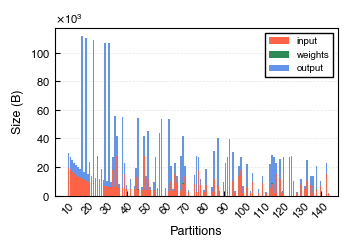

In [56]:
# Generate the plot
fig, ax1 = plot_size_comaprison_2d(
    csv_path=layer_1,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer1_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 1792 rows
After removing duplicates and filtering: 69 rows
Figure saved to: ../data/partitioner_data15Oct/layer2_sizes.png


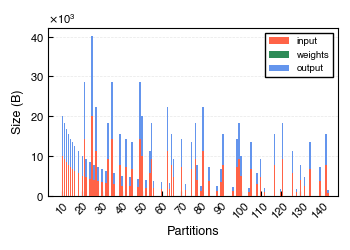

In [57]:
# Generate the plot
fig, ax1 = plot_size_comaprison_2d(
    csv_path=layer_2,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer2_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 1792 rows
After removing duplicates and filtering: 69 rows
Figure saved to: ../data/partitioner_data15Oct/layer3_sizes.png


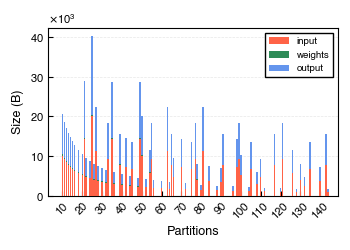

In [58]:
# Generate the plot
fig, ax1 = plot_size_comaprison_2d(
    csv_path=layer_3,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer3_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 1792 rows
After removing duplicates and filtering: 69 rows
Figure saved to: ../data/partitioner_data15Oct/layer4_sizes.png


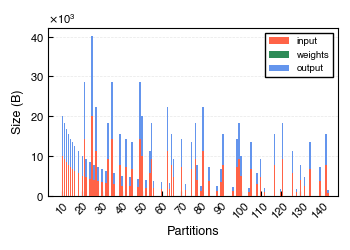

In [59]:
# Generate the plot
fig, ax1 = plot_size_comaprison_2d(
    csv_path=layer_4,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer4_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 3584 rows
After removing duplicates and filtering: 99 rows
Figure saved to: ../data/partitioner_data15Oct/layer5_sizes.png


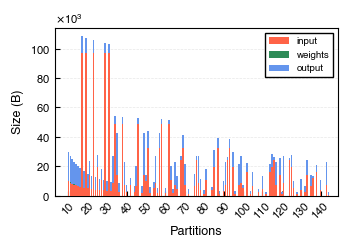

In [60]:
# Generate the plot
fig, ax1 = plot_size_comaprison_2d(
    csv_path=layer_5,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer5_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 7168 rows
After removing duplicates and filtering: 99 rows
Figure saved to: ../data/partitioner_data15Oct/layer7_sizes.png


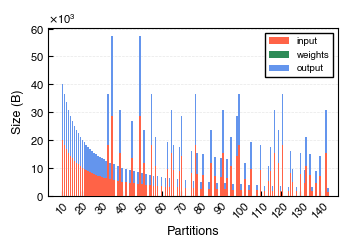

In [61]:
# Generate the plot
fig, ax1 = plot_size_comaprison_2d(
    csv_path=layer_7,
    figsize=(3.5, 2.5),  
    save_path=f'{data_folder}/layer7_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

In [75]:
def plot_size_comparison_3d_scatter(csv_path, figsize=(3.5, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None, scilimits=(1,1)):
    """
    Create IEEE conference paper style 3D scatter plot for NoC comparison.

    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with NoC comparison results
    figsize : tuple
        Figure size in inches (default: 3.5x2.5 for IEEE 2-column)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include (filters out smaller values)
    max_parts_per_layer : int, optional
        Maximum number of partitions per layer to include (filters out larger values)
    scilimits : tuple
        Scientific notation limits for z-axis (default: (1,1))

    Returns:
    --------
    fig, ax : matplotlib objects
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.ticker import ScalarFormatter
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.cm as cm

    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'lines.markersize': 4,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })

    # Read data
    df = pd.read_csv(csv_path)

    # Apply min/max partitions filter if specified
    if min_parts_per_layer is not None:
        df = df[df['num_partitions'] >= min_parts_per_layer]
        print(f"Filtering: showing only num_partitions >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df = df[df['num_partitions'] <= max_parts_per_layer]
        print(f"Filtering: showing only num_partitions <= {max_parts_per_layer}")

    # Sort by parts_per_layer for better visualization
    df_sorted = df.sort_values('num_partitions')

    print(f"Original data: {len(df)} rows")
    print(f"After removing duplicates and filtering: {len(df_sorted)} rows")

    # Get distinct configurations in ascending order
    unique_configs = sorted(df_sorted['partitioning_strategy'].unique())
    # Map configurations to y indices
    config_map = {c: i for i, c in enumerate(unique_configs)}
    df_sorted['config_index'] = df_sorted['partitioning_strategy'].map(config_map)

    # Create 3D figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Create scatter plot with color mapping
    scatter = ax.scatter(
        df_sorted['num_partitions'],
        df_sorted['config_index'],
        df_sorted['mean_partition_size'],
        c=df_sorted['mean_partition_size'],
        cmap='gnuplot',
        s=20,  # marker size
        alpha=0.8,
        edgecolors='none'
    )

    ax.set_xlabel('Partitions', fontweight='normal')
    ax.set_ylabel('Configuration Index', fontweight='normal')
    ax.set_zlabel('Size (B)', fontweight='normal')

    # Set tick parameters
    ax.tick_params(axis='x', direction='in', labelsize=8, width=0.8)
    ax.tick_params(axis='y', direction='in', labelsize=8, width=0.8)
    ax.tick_params(axis='z', direction='in', labelsize=8, width=0.8)

    # Set x ticks
    ax.set_xlim(right=149)

    # Set y ticks to show configuration labels
    ax.set_yticks(range(len(unique_configs)))
    ax.set_yticks(range(0, len(unique_configs), 100))

    # Set scientific notation for z-axis
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits(scilimits)
    ax.zaxis.set_major_formatter(formatter)
    
    # Add colorbar with scientific notation
    cbar = fig.colorbar(scatter, ax=ax, pad=0.2, shrink=0.3, label='Mean Size (B)')
    cbar.ax.yaxis.set_major_formatter(formatter)

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")

    return fig, ax

In [77]:
def plot_size_comparison_3d(csv_path, figsize=(3.5, 2.5), save_path=None, dpi=300, min_parts_per_layer=None, max_parts_per_layer=None, scilimits=(1,1)):
    """
    Create IEEE conference paper style 3D scatter plot for NoC comparison.

    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with NoC comparison results
    figsize : tuple
        Figure size in inches (default: 3.5x2.5 for IEEE 2-column)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    min_parts_per_layer : int, optional
        Minimum number of partitions per layer to include (filters out smaller values)
    max_parts_per_layer : int, optional
        Maximum number of partitions per layer to include (filters out larger values)

    Returns:
    --------
    fig, ax : matplotlib objects
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.ticker import ScalarFormatter
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.cm as cm

    # Set Helvetica font and IEEE style parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'lines.markersize': 4,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })

    # Read data
    df = pd.read_csv(csv_path)

    # Apply min/max partitions filter if specified
    if min_parts_per_layer is not None:
        df = df[df['num_partitions'] >= min_parts_per_layer]
        print(f"Filtering: showing only num_partitions >= {min_parts_per_layer}")
    if max_parts_per_layer is not None:
        df = df[df['num_partitions'] <= max_parts_per_layer]
        print(f"Filtering: showing only num_partitions <= {max_parts_per_layer}")

    # Sort by parts_per_layer for better visualization
    df_sorted = df.sort_values('num_partitions')

    print(f"Original data: {len(df)} rows")
    print(f"After removing duplicates and filtering: {len(df_sorted)} rows")

    # Get distinct configurations in ascending order
    unique_configs = sorted(df_sorted['partitioning_strategy'].unique())
    # Map configurations to y indices
    config_map = {c: i for i, c in enumerate(unique_configs)}
    df_sorted['config_index'] = df_sorted['partitioning_strategy'].map(config_map)

    print(f"Original data: {len(df)} rows")

    # Create 3D figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot scatter for mean_partition_size
    # Surface plot for mean_partition_size
    surf = ax.plot_trisurf(
        df_sorted['num_partitions'],
        df_sorted['config_index'],
        df_sorted['mean_partition_size'],
        cmap='gnuplot',
        linewidth=0.2,
        antialiased=True,
        alpha=0.8
    )

    ax.set_xlabel('Partitions', fontweight='normal')
    ax.set_ylabel('Configuration Index', fontweight='normal')
    ax.set_zlabel('Size (B)', fontweight='normal')

    # Set tick parameters
    ax.tick_params(axis='x', direction='in', labelsize=8, width=0.8)
    ax.tick_params(axis='y', direction='in', labelsize=8, width=0.8)
    ax.tick_params(axis='z', direction='in', labelsize=8, width=0.8)

    # Set x ticks
    ax.set_xlim(right=149)

    # Set y ticks to show configuration labels
    ax.set_yticks(range(len(unique_configs)))
    ax.set_yticks(range(0, len(unique_configs), 100))

    # Set scientific notation for z-axis
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits(scilimits)
    ax.zaxis.set_major_formatter(formatter)
    cbar = fig.colorbar(surf, ax=ax, pad=0.2, shrink=0.3, label='Mean Size (B)')
    cbar.ax.yaxis.set_major_formatter(formatter)

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")

    return fig, ax

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 677 rows
After removing duplicates and filtering: 677 rows
Original data: 677 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer1_sizes.png


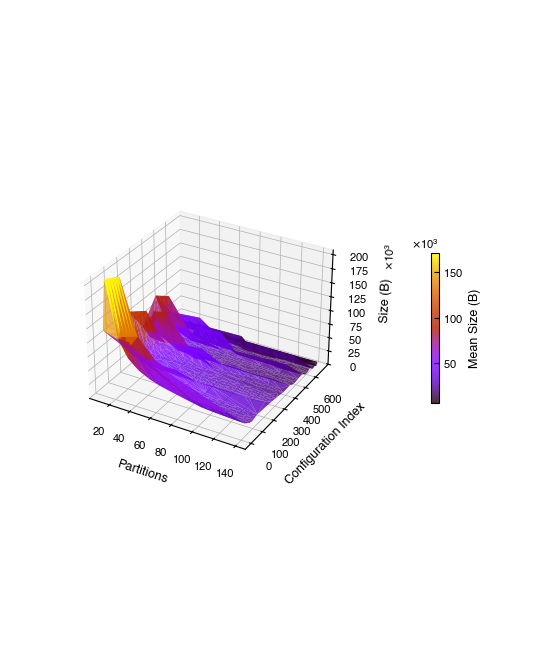

In [78]:
fig, ax = plot_size_comparison_3d(    
    csv_path=layer_1,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer1_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

In [31]:
#%matplotlib widget

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 677 rows
After removing duplicates and filtering: 677 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer1_sizes_scatter.png


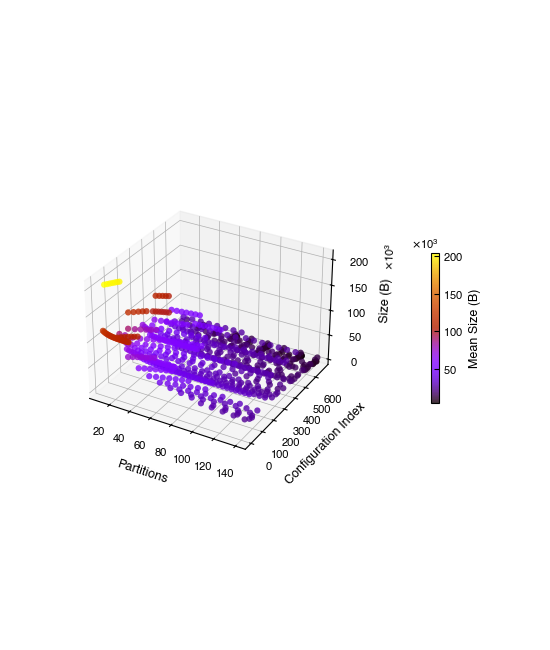

In [76]:
fig, ax = plot_size_comparison_3d_scatter(    
    csv_path=layer_1,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer1_sizes_scatter.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

plt.show()

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 525 rows
After removing duplicates and filtering: 525 rows
Original data: 525 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer2_sizes.png


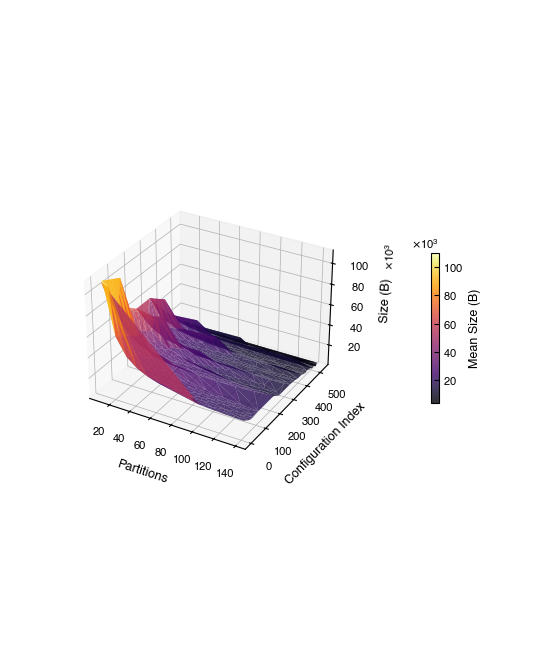

In [10]:
fig, ax = plot_size_comparison_3d(    
    csv_path=layer_2,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer2_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 525 rows
After removing duplicates and filtering: 525 rows
Original data: 525 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer3_sizes.png


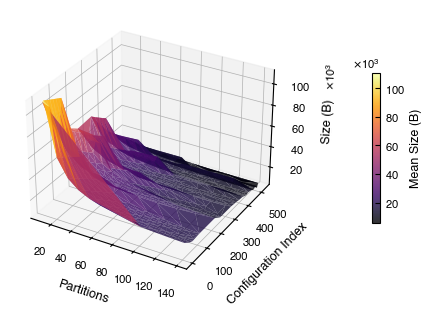

In [195]:
fig, ax = plot_size_comparison_3d(    
    csv_path=layer_3,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer3_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 525 rows
After removing duplicates and filtering: 525 rows
Original data: 525 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer4_sizes.png


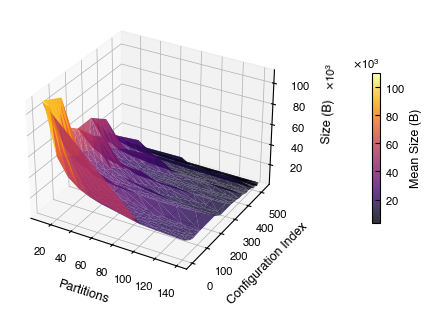

In [196]:
fig, ax = plot_size_comparison_3d(    
    csv_path=layer_4,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer4_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 677 rows
After removing duplicates and filtering: 677 rows
Original data: 677 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer5_sizes.png


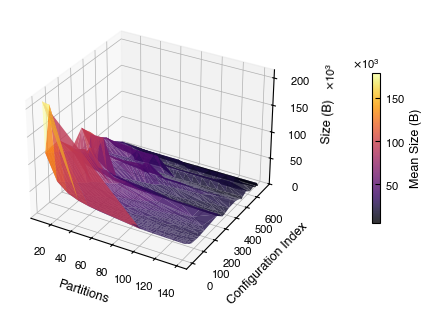

In [197]:
fig, ax = plot_size_comparison_3d(    
    csv_path=layer_5,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer5_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)

Filtering: showing only num_partitions >= 10
Filtering: showing only num_partitions <= 144
Original data: 829 rows
After removing duplicates and filtering: 829 rows
Original data: 829 rows
Figure saved to: ../data/partitioner_data15Oct/3d_layer7_sizes.png


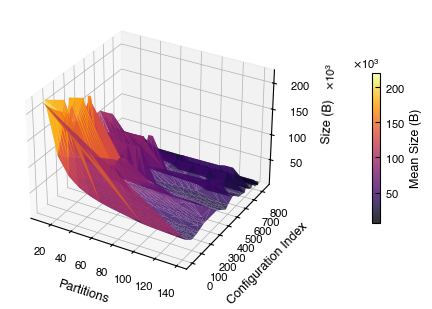

In [198]:
fig, ax = plot_size_comparison_3d(    
    csv_path=layer_7,
    figsize=(5.5, 6.5),  
    save_path=f'{data_folder}/3d_layer7_sizes.png',
    dpi=500,
    min_parts_per_layer=10, 
    max_parts_per_layer=144,
    scilimits=(3,3)
)